# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s): 
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




### Get the BSDS500 dataset

In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ /content/data/

In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ /content/data/

In [22]:
import numpy as np
import cv2
from scipy.ndimage import rotate
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"

In [4]:

def gaussian_kernel(size, sigma):
    """Generates a Gaussian kernel."""
    axis = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(axis, axis)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

def img_pad(image, pad_height, pad_width):
     image_height, image_width = image.shape
     padded_image = np.zeros((image_height + 2 * pad_height, image_width + 2 * pad_width), dtype=image.dtype)
     padded_image[pad_height:pad_height+image_height,pad_width:pad_width+image_width] = image
     return padded_image

def rotate_sobel(angle):
    """Rotates the Sobel filter to the specified angle."""
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    rotated = rotate(sobel_x, angle, reshape=False, order=1, mode='constant', cval=0)
    return rotated

def convolution(image, kernel):
	kernel_height, kernel_width = kernel.shape
	image_height, image_width = image.shape
	output = np.zeros((image_height, image_width), dtype=image.dtype)
	padding_height, padding_width = kernel_height // 2, kernel_width // 2
	
	padded_image = img_pad(image, padding_height, padding_width)
	# padded_image = np.pad(image, padding_height, mode='constant', constant_values=0)
	
	for i in range(image_height):
		for j in range(image_width):     
			output[i, j] = np.sum(padded_image[i:i+kernel_height, j:j+kernel_width] * kernel)  
	return output


def create_filter_grid(filters, rows, cols, filter_size, padding=5):
    """Combines filters into a grid layout."""
    grid_height = rows * filter_size + (rows - 1) * padding
    grid_width = cols * filter_size + (cols - 1) * padding
    grid = np.zeros((grid_height, grid_width), dtype=np.uint8)

    for i, filter_image in enumerate(filters):
        row = i // cols
        col = i % cols
        y_start = row * (filter_size + padding)
        x_start = col * (filter_size + padding)
        grid[y_start:y_start + filter_size, x_start:x_start + filter_size] = filter_image

    return grid


# Main code
kernel_size = 13
filter_size = 48  # Size of each filter in the grid
angles = range(0, 360, 15)  # Rotation angles for Sobel filter
scales = [1.0, 1.5]  # Different Gaussian kernel scales
gaussian_filters_bank = []

# Generate Gaussian kernels and convolve with rotated Sobel filters
for sigma in scales:
    gaussian = gaussian_kernel(kernel_size, sigma)

    for angle in angles:
        rotated_sobel = rotate_sobel(angle)  # Rotate the Sobel filter
        convolved = convolution(gaussian, rotated_sobel)
        # Normalize and resize the filter for visualization
        normalized = cv2.normalize(convolved, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        resized = cv2.resize(normalized, (filter_size, filter_size), interpolation=cv2.INTER_LINEAR)
        gaussian_filters_bank.append(resized)

# Create and save the filter grid
rows = len(scales)  # Each row represents one Gaussian scale
cols = len(angles)  # Each column represents one orientation angle
filter_grid = create_filter_grid(gaussian_filters_bank, rows, cols, filter_size)

output_path = "DoG_rotated_grid_fixed_new1.png"
cv2.imwrite(output_path, filter_grid)

print(f"Fixed filter grid saved as {output_path}")

Fixed filter grid saved as DoG_rotated_grid_fixed_new1.png



1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"


In [5]:
def first_derivative_gaussian(size, sigma, orientation):
    """Generates the first derivative of Gaussian filter with elongation."""
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(ax, ax)
    theta = np.deg2rad(orientation)
    
    # Apply elongation factor (σy = 3σx)
    sigma_y = 3 * sigma
    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)
    
    # Use different sigma for x and y directions
    gauss = np.exp(-(x_rot**2 / (2 * sigma**2) + y_rot**2 / (2 * sigma_y**2)))
    derivative = -x_rot * gauss / (sigma**2)
    
    # Normalize
    return derivative / np.abs(derivative).sum()

def second_derivative_gaussian(size, sigma, orientation):
    """Generates the second derivative of Gaussian filter with elongation."""
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(ax, ax)
    theta = np.deg2rad(orientation)
    
    # Apply elongation factor (σy = 3σx)
    sigma_y = 3 * sigma
    x_rot = x * np.cos(theta) + y * np.sin(theta)
    y_rot = -x * np.sin(theta) + y * np.cos(theta)
    
    # Use different sigma for x and y directions
    gauss = np.exp(-(x_rot**2 / (2 * sigma**2) + y_rot**2 / (2 * sigma_y**2)))
    derivative = (x_rot**2 / (sigma**4) - 1 / (sigma**2)) * gauss
    
    # Normalize
    return derivative / np.abs(derivative).sum()

def laplacian_of_gaussian(size, sigma):
    """Generates the Laplacian of Gaussian (LoG) filter."""
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(ax, ax)
    return ((x**2 + y**2 - 2 * sigma**2) / sigma**4) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

def gaussian_filter(size, sigma):
    """Generates a 2D Gaussian smoothing filter."""
    return cv2.getGaussianKernel(size, sigma) @ cv2.getGaussianKernel(size, sigma).T

def normalize_filter(filter_image):
    """Normalize a filter image to the range [0, 255]."""
    filter_norm = (filter_image - filter_image.min()) / (filter_image.max() - filter_image.min())
    return (filter_norm * 255).astype(np.uint8)

def create_filter_grid(filters, rows, cols, filter_size, output_filename, padding=5, border_color=0):
    """Combines filters into a grid layout and saves as an image."""
    grid_height = rows * filter_size + (rows - 1) * padding
    grid_width = cols * filter_size + (cols - 1) * padding
    grid = np.full((grid_height, grid_width), border_color, dtype=np.uint8)

    for i, filter_image in enumerate(filters):
        if i >= rows * cols:
            break
        # Normalize filter
        filter_image = normalize_filter(filter_image)
        if filter_image.shape[0] != filter_size:
            filter_image = cv2.resize(filter_image, (filter_size, filter_size), 
                                   interpolation=cv2.INTER_CUBIC)
        
        row, col = divmod(i, cols)
        y_start = row * (filter_size + padding)
        x_start = col * (filter_size + padding)
        grid[y_start:y_start + filter_size, x_start:x_start + filter_size] = filter_image

    cv2.imwrite(output_filename, grid)

# Main script to generate LM filter bank
if __name__ == "__main__":
    # Define parameters for LMS (LM Small)
    scales = [1, np.sqrt(2), 2, 2*np.sqrt(2)]  # Basic scales for LMS
    orientations = np.linspace(0, 180, 6, endpoint=False)  # 6 orientations
    size = 49  # Size of filters
    lms_filters_bank = []

    # Generate first and second derivative filters
    for sigma in scales[:3]:  # First three scales only
        for orientation in orientations:
            # First derivative
            lms_filters_bank.append(first_derivative_gaussian(size, sigma, orientation))
            
        for orientation in orientations:
            # Second derivative
            lms_filters_bank.append(second_derivative_gaussian(size, sigma, orientation))


        # Generate Laplacian of Gaussian filters
    for sigma in [1, np.sqrt(2), 2, 2 * np.sqrt(2)]:
        lms_filters_bank.append(laplacian_of_gaussian(size, sigma))      # At σ

    for sigma in [1, np.sqrt(2), 2, 2 * np.sqrt(2)]:
        lms_filters_bank.append(laplacian_of_gaussian(size, 3 * sigma))

    # Generate Gaussian smoothing filters
    for sigma in [1, np.sqrt(2), 2, 2 * np.sqrt(2)]:
        lms_filters_bank.append(gaussian_filter(size, sigma))

    # Verify we have 48 filters
    assert len(lms_filters_bank) == 48, f"Generated {len(lms_filters_bank)} filters instead of 48"

    # Save the filter grid
    create_filter_grid(
        filters=lms_filters_bank,
        rows=4,
        cols=12,
        filter_size=64,
        output_filename="lms_filters_corrected_new.png",
        padding=5,
        border_color=0
    )

    scales = [np.sqrt(2), 2, 2*np.sqrt(2),4]  # Basic scales for LMS
    orientations = np.linspace(0, 180, 6, endpoint=False)  # 6 orientations
    size = 49  # Size of filters
    lml_filters_bank = []

    for sigma in scales[:3]:  # First three scales only
        for orientation in orientations:
            # First derivative
            lml_filters_bank.append(first_derivative_gaussian(size, sigma, orientation))
            
        for orientation in orientations:
            # Second derivative
            lml_filters_bank.append(second_derivative_gaussian(size, sigma, orientation))
    
    print(f"Derivative:{len(lml_filters_bank)}")


    # Generate Laplacian of Gaussian filters
    for sigma in scales:
        lml_filters_bank.append(laplacian_of_gaussian(size, sigma))      # At σ
    
    print(f"σ Laplcian Gaussian:{len(lml_filters_bank)}")

    for sigma in scales:
        lml_filters_bank.append(laplacian_of_gaussian(size, 3 * sigma))
    
    print(f"3*σ Laplcian Gaussian:{len(lml_filters_bank)}")

    # Generate Gaussian smoothing filters
    for sigma in scales:
        lml_filters_bank.append(gaussian_filter(size, sigma))
    

        # Verify we have 48 filters
    assert len(lml_filters_bank) == 48, f"Generated {len(lml_filters_bank)} filters instead of 48"

    # Save the filter grid
    create_filter_grid(
        filters=lml_filters_bank,
        rows=4,
        cols=12,
        filter_size=64,
        output_filename="lml_filters_corrected.png",
        padding=5,
        border_color=0
    )


Derivative:36
σ Laplcian Gaussian:40
3*σ Laplcian Gaussian:44


1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"


In [6]:
import numpy as np
import cv2

def gabor_filter(size, sigma, orientation, omega):
    """Generates a Gabor filter."""
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(ax, ax)
    theta = np.deg2rad(orientation)

    # Rotate coordinates
    c, s = np.cos(theta), np.sin(theta)
    x_rotated = x * c + y * s
    y_rotated = -x * s + y * c

    # Gaussian and sinusoidal components
    gaussian = np.exp(-(x_rotated**2 / (2 * sigma**2) + y_rotated**2 / (2 * sigma**2)))
    sine = np.sin(omega * x_rotated)

    # Combine to create Gabor filter
    gabor = gaussian * sine
    return gabor

def normalize_filter(filter_image):
    """Normalizes a filter image to the range [0, 255]."""
    filter_norm = (filter_image - filter_image.min()) / (filter_image.max() - filter_image.min())
    return (filter_norm * 255).astype(np.uint8)

def create_filter_grid(filters, rows, cols, filter_size, output_filename, padding=5, border_color=255):
    """Combines filters into a grid layout and saves as an image."""
    grid_height = rows * filter_size + (rows - 1) * padding
    grid_width = cols * filter_size + (cols - 1) * padding
    grid = np.full((grid_height, grid_width), border_color, dtype=np.uint8)

    for i, filter_image in enumerate(filters):
        if i >= rows * cols:
            break
        # Normalize filter
        filter_image = normalize_filter(filter_image)
        if filter_image.shape[0] != filter_size:
            filter_image = cv2.resize(filter_image, (filter_size, filter_size), interpolation=cv2.INTER_CUBIC)

        row, col = divmod(i, cols)
        y_start = row * (filter_size + padding)
        x_start = col * (filter_size + padding)
        grid[y_start:y_start + filter_size, x_start:x_start + filter_size] = filter_image

    cv2.imwrite(output_filename, grid)

# Main script to generate Gabor filters
if __name__ == "__main__":
    # Refined Parameters
    orientation_range = np.linspace(0, 180, 8, endpoint=False)  # 8 orientations evenly spaced
    sigma_range = [6, 7, 9, 11, 13]  # More compact Gaussian spreads
    omega_range = [0.3, 0.4, 0.5, 0.6, 0.7]  # Sinusoidal frequencies
    kernel_size = 37  # Keep filters compact

    gabor_filters_bank = []

    # Generate Gabor filters
    for i, sigma in enumerate(sigma_range):
        for orientation in orientation_range:
            gabor_filters_bank.append(gabor_filter(kernel_size, sigma, orientation, omega_range[i]))

    # Save the filter grid (5 rows × 8 columns)
    create_filter_grid(
        filters=gabor_filters_bank,
        rows=5,
        cols=8,
        filter_size=64,  # Rescale filters to 64x64 for visualization
        output_filename="refined_gabor_filters_grid_updated_new.png",
        padding=5,  # Reduce padding for a compact grid
        border_color=255  # Use white background
    )

    print("Refined filter grid saved as 'refined_gabor_filters_grid_updated.png'")


Refined filter grid saved as 'refined_gabor_filters_grid_updated.png'


In [30]:
filter_bank = []
count = 0
LM_filter_bank = []

for i in range(len(gaussian_filters_bank)):
    if len(gaussian_filters_bank[i].shape) == 2:
        filter_bank.append(gaussian_filters_bank[i])
        count = count + 1

for i in range(len(lms_filters_bank)):
    if len(lms_filters_bank[i].shape) == 2:
        filter_bank.append(lms_filters_bank[i])
        LM_filter_bank.append(lms_filters_bank[i])
        count = count + 1

for i in range(len(lml_filters_bank)):
    if len(lml_filters_bank[i].shape) == 2:
        filter_bank.append(lml_filters_bank[i])
        LM_filter_bank.append(lml_filters_bank[i])
        count = count + 1

for i in range(len(gabor_filters_bank)):
    if len(gabor_filters_bank[i].shape) == 2:
        filter_bank.append(gabor_filters_bank[i])
        count = count + 1

print(len(filter_bank))
print(count)


184
184


1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

In [ ]:
def half_disk_mask(radius):
    """Generates a half-disk mask."""
    half_disk = np.zeros((radius * 2, radius * 2), dtype=np.uint8)  # Correct initialization
    for i in range(radius * 2):
        for j in range(radius * 2):
            if (i - radius)**2 + (j - radius)**2 < radius**2 and i <= radius:
                half_disk[i, j] = 1
    return half_disk


def normalize_filter(filter_image):
    """Normalizes a filter image to the range [0, 255]."""
    return (filter_image * 255).astype(np.uint8)

def create_image_grid(filters, rows, cols, filter_size, output_filename, padding=5, border_color=255):
    """Combines filters into a grid layout and saves as an image."""
    grid_height = rows * filter_size + (rows - 1) * padding
    grid_width = cols * filter_size + (cols - 1) * padding
    grid = np.full((grid_height, grid_width), border_color, dtype=np.uint8)

    for i, filter_image in enumerate(filters):
        if i >= rows * cols:
            break
        if filter_image.shape[0] != filter_size:
            filter_image = cv2.resize(filter_image, (filter_size, filter_size), interpolation=cv2.INTER_CUBIC)

        row, col = divmod(i, cols)
        y_start = row * (filter_size + padding)
        x_start = col * (filter_size + padding)
        grid[y_start:y_start + filter_size, x_start:x_start + filter_size] = filter_image

    cv2.imwrite(output_filename, grid)

if __name__ == '__main__':

    hd_orients = np.arange(0,360,360/8)
    radius_sizes = np.array([5,10,15])

    left_mask = []
    right_mask = []
    masks = []

    for i in range(len(radius_sizes)):
        hd_mask = half_disk_mask(radius_sizes[i])
        for k in range(len(hd_orients)):
            mask_1 = rotate(hd_mask, hd_orients[i])
            left_mask.append(mask_1)
            masks.append(mask_1)
            mask_2 = rotate(mask_1, 180)
            right_mask.append(mask_2)
            masks.append(mask_2)
    
    masks = [normalize_filter(mask) for mask in masks]

    # Save combined grid (8 columns × 6 rows)
    create_image_grid(
        filters=masks,
        rows=6,
        cols=8,
        filter_size=64,
        output_filename="combined_half_disks_grid_new.png",
        padding=5,
        border_color=255  # Use white background
    )

print("Combined half-disk grid saved as 'combined_half_disks_grid.png'.")


Combined half-disk grid saved as 'combined_half_disks_grid.png'.


1. Generate Texton Map
2. Filter image using oriented gaussian filter bank


Starting texton computation
Finished texton computations
154401


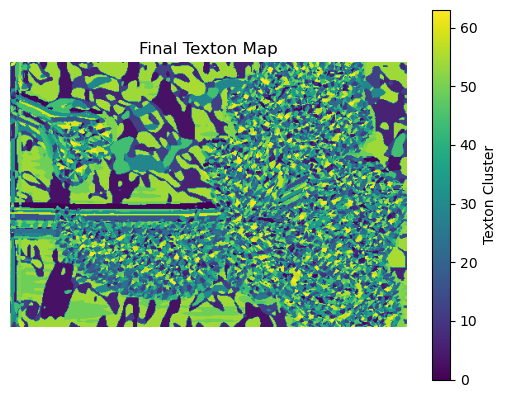

In [85]:
img = cv2.imread("Phase1/BSDS500/Images/2.jpg")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# filter_bank

data = np.zeros((gray_img.size, len(filter_bank)))

print("Starting texton computation")

for i in range(0, len(filter_bank)):
    temp = cv2.filter2D(gray_img, -1, filter_bank[i])
    temp = temp.reshape((1, gray_img.size))
    # data[:,i] = temp.flatten()
    data[:,i] = temp


print("Finished texton computations")

# Perform clustering on the filter responses
n_clusters = 64  # Number of texton clusters
kmeans = KMeans(n_clusters=n_clusters, n_init= 4).fit(data)

# Reshape clustered labels into the original image dimensions
texton_map = kmeans.labels_.reshape(gray_img.shape)
print(texton_map.size)
# Visualize the texton map
plt.imshow(texton_map, cmap='viridis')
plt.title("Final Texton Map")
plt.axis("off")
plt.colorbar(label="Texton Cluster")
plt.show()


In [ ]:
# import cv2
# import os
# import numpy as np
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # Parameters
# input_folder = "Phase1/BSDS500/Images"  # Folder containing input images
# output_folder = "images_texton_maps"    # Folder to save texton maps
# n_clusters = 64                         # Number of texton clusters

# # Create output folder if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

# # List all image files in the input folder
# image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
# image_files.sort()  # Optional: process files in sorted order

# # Process each image
# for image_file in image_files:
#     # Load the image
#     input_path = os.path.join(input_folder, image_file)
#     img = cv2.imread(input_path)

#     # Check if image is loaded successfully
#     if img is None:
#         print(f"Failed to load {image_file}. Skipping...")
#         continue

#     # Convert to grayscale
#     gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Initialize data matrix
#     data = np.zeros((gray_img.size, len(filter_bank)))

#     print(f"Processing {image_file} - Starting texton computation")

#     # Apply each filter in the filter bank
#     for i in range(len(filter_bank)):
#         temp = cv2.filter2D(gray_img, -1, filter_bank[i])  # Filter the image
#         temp = temp.reshape((1, gray_img.size))           # Flatten the filtered image
#         data[:, i] = temp                                 # Store filter responses

#     print(f"Finished texton computation for {image_file}")

#     # Perform clustering on the filter responses
#     kmeans = KMeans(n_clusters=n_clusters, n_init=4, random_state=42).fit(data)

#     # Reshape clustered labels into the original image dimensions
#     texton_map = kmeans.labels_.reshape(gray_img.shape)

#     # Save the texton map using matplotlib
#     output_path = os.path.join(output_folder, f"texton_map_{os.path.splitext(image_file)[0]}.png")
#     plt.figure(figsize=(10, 8))
#     plt.imshow(texton_map, cmap='viridis')
#     plt.axis('off')  # Remove axes for clean visualization
#     plt.colorbar(label="Texton Cluster")
#     plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
#     plt.close()

#     print(f"Texton map saved for {image_file} at {output_path}")

# print("All images processed and texton maps saved.")


Processing 1.jpg - Starting texton computation
Finished texton computation for 1.jpg
Texton map saved for 1.jpg at images_texton_maps/texton_map_1.png
Processing 10.jpg - Starting texton computation
Finished texton computation for 10.jpg
Texton map saved for 10.jpg at images_texton_maps/texton_map_10.png
Processing 2.jpg - Starting texton computation
Finished texton computation for 2.jpg
Texton map saved for 2.jpg at images_texton_maps/texton_map_2.png
Processing 3.jpg - Starting texton computation
Finished texton computation for 3.jpg
Texton map saved for 3.jpg at images_texton_maps/texton_map_3.png
Processing 4.jpg - Starting texton computation
Finished texton computation for 4.jpg
Texton map saved for 4.jpg at images_texton_maps/texton_map_4.png
Processing 5.jpg - Starting texton computation
Finished texton computation for 5.jpg
Texton map saved for 5.jpg at images_texton_maps/texton_map_5.png
Processing 6.jpg - Starting texton computation
Finished texton computation for 6.jpg
Texto

1. Generate texture ID's using K-means clustering
2. Display texton map and save image as TextonMap_ImageName.png,
3. use command "cv2.imwrite('...)"


In [32]:
# Done Above

1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"


Starting gradient computation
Calculating gradient map
Gradient computation completed
(321, 481)


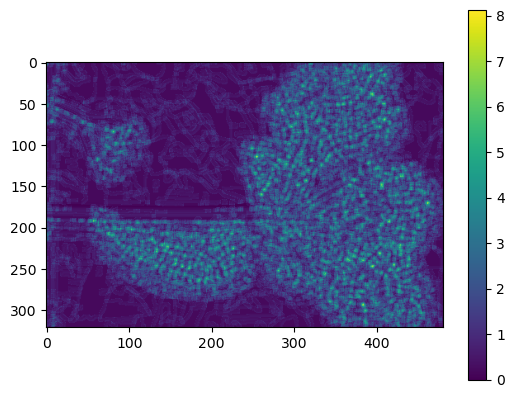

In [86]:
# # texton_map for 9

def create_binary_image_vectorized(img, num_bins):
    """
    Vectorized creation of binary images for all bin values.
    Returns a stack of binary images of shape (num_bins-1, H, W).
    """

    binary_img = np.array([(img == bin_value).astype(np.uint8) for bin_value in range(1, num_bins)])
    
    return binary_img

def gradient(property_map, num_bins, mask_left, mask_right):
    """
    Calculate the gradient map using chi-square between left and right masks.
    """
    print("Calculating gradient map")
    # Create binary images for all bins
    binary_images = create_binary_image_vectorized(property_map, num_bins)
    
    # Initialize gradient map for 24 orientations
    gradient_map = np.zeros((property_map.shape[0], property_map.shape[1], 24))
    
    for m in range(24):
        chi_squared = np.zeros(property_map.shape)
        
        # Apply masks and compute chi-square for all bins
        for binary_image in binary_images:
            conv_left = cv2.filter2D(binary_image, -1, mask_left[m])
            conv_right = cv2.filter2D(binary_image, -1, mask_right[m])
            denominator = conv_left + conv_right + 1e-6  # Avoid division by zero
            chi_squared += ((conv_left - conv_right) ** 2) / denominator
        
        gradient_map[:, :, m] = chi_squared
    
    return gradient_map

if __name__ == "__main__":
    print("Starting gradient computation")

    # Compute gradient
    Tg = gradient(texton_map, 64, left_mask, right_mask)
    print("Gradient computation completed")

    # Take the mean across orientations
    tgm = np.mean(Tg, axis=2)
    print(tgm.shape)
    # Save and show the result
    plt.imsave("Tg_9_new.png", tgm, cmap='viridis')
    plt.imshow(tgm, cmap='viridis')
    plt.colorbar()
    plt.show()



1. Generate Brightness Map
2. Perform brightness binning


(321, 481)


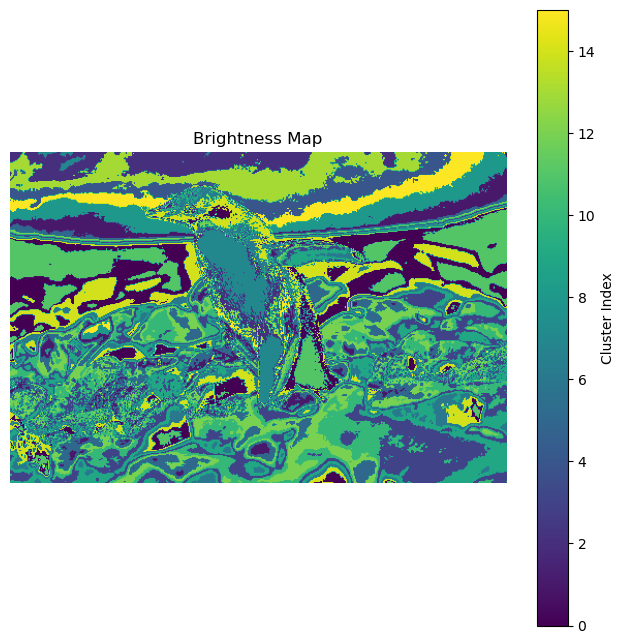

In [71]:
def generate_brightness_map(image_path, num_clusters=16):
    """
    Generate a brightness map by clustering the brightness levels in an image.
    
    Parameters:
    - image_path: Path to the input image.
    - num_clusters: Number of clusters for k-means clustering (default is 16).
    
    Returns:
    - brightness_map: The clustered brightness map as a 2D array.
    """
    # Step 1: Read the image and check if it exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Error: The file '{image_path}' does not exist.")

    image = cv2.imread(image_path)  # Load the image
    if image is None:
        raise ValueError(f"Error: Could not load the image at path '{image_path}'. Please check the file format.")

    # Step 2: Convert to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 3: Flatten the grayscale image into a 1D array
    flattened = grayscale.flatten().reshape(-1, 1)  # Shape: (H*W, 1)

    # Step 4: Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(flattened)
    clustered = kmeans.labels_  # Cluster labels for each pixel

    # Step 5: Reshape clustered labels back to the image dimensions
    brightness_map = clustered.reshape(grayscale.shape)  # Shape: (H, W)
    print(brightness_map.shape)
    return brightness_map

if __name__ == "__main__":
    # Input image path
    image_path = "Phase1/BSDS500/Images/7.jpg"  # Update to your image's actual path

    try:
        # Generate brightness map
        brightness_map = generate_brightness_map(image_path, num_clusters=16)

        # Plot the brightness map
        plt.figure(figsize=(8, 8))
        plt.imshow(brightness_map, cmap='viridis')  # Use a colormap to visualize clusters
        plt.colorbar(label="Cluster Index")
        plt.title("Brightness Map")
        plt.axis("off")
        plt.show()

    except FileNotFoundError as e:
        print(e)
    except ValueError as e:
        print(e)

1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



Calculating gradient map
Gradient computation completed
(321, 481)


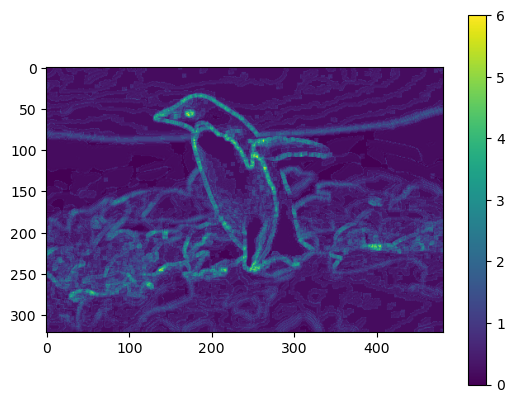

In [ ]:
Bg = gradient(brightness_map, 16, left_mask, right_mask)
print("Gradient computation completed")

# Take the mean across orientations
bgm = np.mean(Bg, axis=2)
print(bgm.shape)
# Save and show the result
plt.imsave("Bg_9_new.png", bgm, cmap='viridis')
plt.imshow(bgm, cmap='viridis')
plt.colorbar()
plt.show()

1. Generate Color Map
2. Perform color binning or clustering


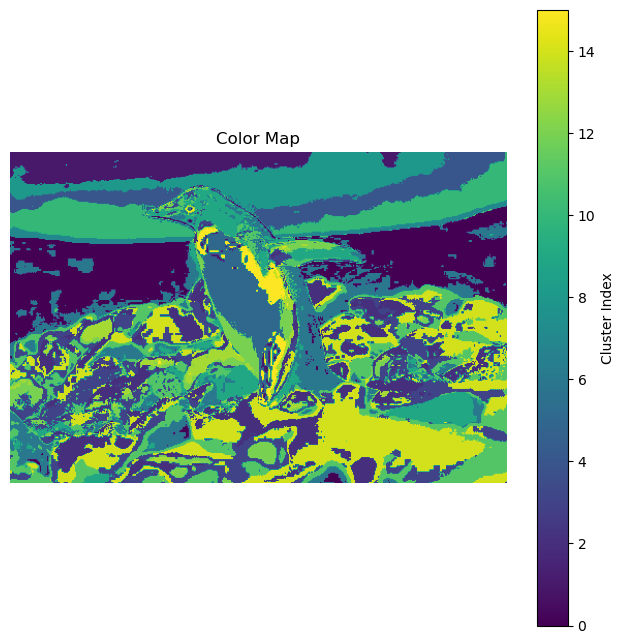

In [73]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

def generate_color_map(image_path, num_clusters=16):
    """
    Generate a color map by clustering the color values in an image.

    Parameters:
    - image_path: Path to the input image.
    - num_clusters: Number of clusters for k-means clustering (default is 16).
    - color_space: The color space to use ('RGB', 'YCbCr', 'HSV', 'Lab').

    Returns:
    - color_map: The clustered color map as a 2D array of cluster labels.
    """
    # Step 1: Read the image and check if it exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Error: The file '{image_path}' does not exist.")

    image = cv2.imread(image_path)  # Load the image
    if image is None:
        raise ValueError(f"Error: Could not load the image at path '{image_path}'. Please check the file format.")

    # Step 2: Convert to the color space
    color_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Step 3: Flatten the image into a 2D array
    flattened = color_image.reshape(-1, 3)  # Shape: (H*W, 3)

    # Step 4: Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(flattened)
    clustered = kmeans.labels_  # Cluster labels for each pixel

    # Step 5: Reshape clustered labels back to the image dimensions
    color_map = clustered.reshape(color_image.shape[:2])  # Shape: (H, W)

    return color_map

if __name__ == "__main__":
    # Input image path
    image_path = "Phase1/BSDS500/Images/7.jpg"  # Update to your image's actual path

    try:
        # Generate color map
        color_map = generate_color_map(image_path, num_clusters=16)  # Choose desired color space

        # Plot the color map
        plt.figure(figsize=(8, 8))
        plt.imshow(color_map, cmap='viridis')  # Use a colormap to visualize clusters
        plt.colorbar(label="Cluster Index")
        plt.title("Color Map")
        plt.axis("off")
        plt.show()

    except FileNotFoundError as e:
        print(e)
    except ValueError as e:
        print(e)





1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"



Calculating gradient map
Gradient computation completed


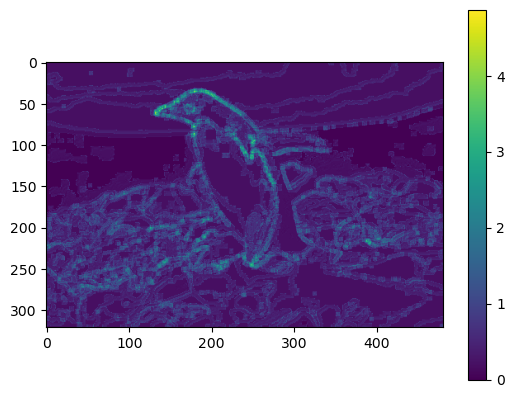

In [74]:
Cg = gradient(color_map, 16, left_mask, right_mask)
print("Gradient computation completed")

# Take the mean across orientations
cgm = np.mean(Cg, axis=2)

# Save and show the result
plt.imsave("Cg_9_new.png", cgm, cmap='viridis')
plt.imshow(cgm, cmap='viridis')
plt.colorbar()
plt.show()


1. Read Sobel Baseline
2. use command "cv2.imread(...)"


In [78]:
sobel_baseline = cv2.imread("Phase1/BSDS500/SobelBaseline/7.png")




1. Read Canny Baseline
2. use command "cv2.imread(...)"



In [79]:
canny_baseline = cv2.imread("Phase1/BSDS500/CannyBaseline/7.png")



1. Combine responses to get pb-lite output
2. Display PbLite and save image as PbLite_ImageName.png
3. use command "cv2.imwrite(...)"



(321, 481)
(321, 481)
(321, 481)


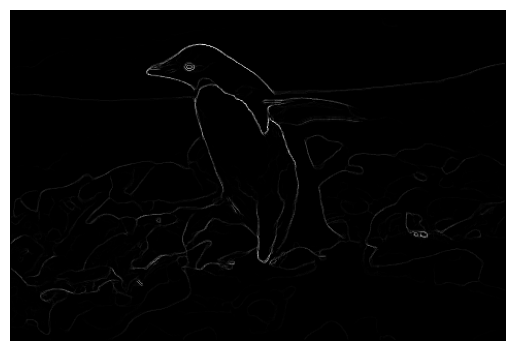

In [80]:
sobel_gray = cv2.cvtColor(sobel_baseline, cv2.COLOR_BGR2GRAY)
canny_gray = cv2.cvtColor(canny_baseline, cv2.COLOR_BGR2GRAY)

w = 0.5
print(tgm.shape)
print(bgm.shape)
print(cgm.shape)
avg = (tgm + bgm + cgm) / 3

cs = w * canny_gray + (1 - w) * sobel_gray
pb = np.multiply(avg, cs)

plt.imshow(pb, cmap="gray")
plt.axis('off')
plt.show()

# Save the image with a proper extension
plt.imsave("Pb_Lite.png", pb, cmap="gray")  # Added ".png" extension

## Phase 2

### Neural Network Construction

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def loss_fn(out, labels):
    ###############################################
       #Fill your loss function of choice here!#
    ###############################################
    loss = ...
    return loss

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = loss_fn(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = loss_fn(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'loss': loss.detach(), 'acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, result['loss'], result['acc']))



class CIFAR10Model(ImageClassificationBase):
  def __init__(self, InputSize, OutputSize):
      """
      Inputs: 
      InputSize - Size of the Input
      OutputSize - Size of the Output
      """
      #############################
      # Fill your network initialization of choice here!
      #############################

      
  def forward(self, xb):
      """
      Input:
      xb is a MiniBatch of the current image
      Outputs:
      out - output of the network
      """
      #############################
      # Fill your network structure of choice here!
      #############################
     
      return out
      

In [ ]:
import time
import glob
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

def tic():
    """
    Function to start timer
    Tries to mimic tic() toc() in MATLAB
    """
    StartTime = time.time()
    return StartTime

def toc(StartTime):
    """
    Function to stop timer
    Tries to mimic tic() toc() in MATLAB
    """
    return time.time() - StartTime

def FindLatestModel(CheckPointPath):
    """
    Finds Latest Model in CheckPointPath
    Inputs:
    CheckPointPath - Path where you have stored checkpoints
    Outputs:
    LatestFile - File Name of the latest checkpoint
    """
    FileList = glob.glob(CheckPointPath + '*.ckpt.index') # * means all if need specific format then *.csv
    LatestFile = max(FileList, key=os.path.getctime)
    # Strip everything else except needed information
    LatestFile = LatestFile.replace(CheckPointPath, '')
    LatestFile = LatestFile.replace('.ckpt.index', '')
    return LatestFile


def convertToOneHot(vector, NumClasses):
    """
    Inputs:
    vector - vector of argmax indexes
    NumClasses - Number of classes
    """
    return np.equal.outer(vector, np.arange(NumClasses)).astype(np.float)

### Train your neural network

In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
import cv2
import sys
import os
import numpy as np
import random
import skimage
import PIL
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
from termcolor import colored, cprint
import math as m
from tqdm.notebook import tqdm

def SetupAll(CheckPointPath):
    """
    Inputs: 
    CheckPointPath - Path to save checkpoints/model
    Outputs:
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    ImageSize - Size of the image
    NumTrainSamples - length(Train)
    TrainLabels - Labels corresponding to Train
    NumClasses - Number of classes
    """
    # Read and Setup Labels
    LabelsPathTrain = '/content/data/TxtFiles/LabelsTrain.txt'
    TrainLabels = ReadLabels(LabelsPathTrain)

    # If CheckPointPath doesn't exist make the path
    if(not (os.path.isdir(CheckPointPath))):
       os.makedirs(CheckPointPath)
        
    # Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    SaveCheckPoint = 100 
    
    # Image Input Shape
    ImageSize = [32, 32, 3]
    NumTrainSamples = len(TrainSet)

    # Number of classes
    NumClasses = 10

    return SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses


def ReadLabels(LabelsPathTrain):
    if(not (os.path.isfile(LabelsPathTrain))):
        print('ERROR: Train Labels do not exist in '+LabelsPathTrain)
        sys.exit()
    else:
        TrainLabels = open(LabelsPathTrain, 'r')
        TrainLabels = TrainLabels.read()
        TrainLabels = map(float, TrainLabels.split())

    return TrainLabels
    

def ReadDirNames(ReadPath):
    """
    Inputs: 
    ReadPath is the path of the file you want to read
    Outputs:
    DirNames is the data loaded from /content/data/TxtFiles/DirNames.txt which has full path to all image files without extension
    """
    # Read text files
    DirNames = open(ReadPath, 'r')
    DirNames = DirNames.read()
    DirNames = DirNames.split()
    return DirNames

    
def GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize):
    """
    Inputs: 
    TrainSet - Variable with Subfolder paths to train files
    NOTE that Train can be replaced by Val/Test for generating batch corresponding to validation (held-out testing in this case)/testing
    TrainLabels - Labels corresponding to Train
    NOTE that TrainLabels can be replaced by Val/TestLabels for generating batch corresponding to validation (held-out testing in this case)/testing
    ImageSize is the Size of the Image
    MiniBatchSize is the size of the MiniBatch
   
    Outputs:
    I1Batch - Batch of images
    LabelBatch - Batch of one-hot encoded labels 
    """
    I1Batch = []
    LabelBatch = []
    
    ImageNum = 0
    while ImageNum < MiniBatchSize:
        # Generate random image
        RandIdx = random.randint(0, len(TrainSet)-1)
        
        ImageNum += 1
    	
    	  ##########################################################
    	  # Add any standardization or data augmentation here!
    	  ##########################################################

        I1, Label = TrainSet[RandIdx]

        # Append All Images and Mask
        I1Batch.append(I1)
        LabelBatch.append(torch.tensor(Label))
        
    return torch.stack(I1Batch), torch.stack(LabelBatch)


def PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile):
    """
    Prints all stats with all arguments
    """
    print('Number of Epochs Training will run for ' + str(NumEpochs))
    print('Factor of reduction in training data is ' + str(DivTrain))
    print('Mini Batch Size ' + str(MiniBatchSize))
    print('Number of Training Images ' + str(NumTrainSamples))
    if LatestFile is not None:
        print('Loading latest checkpoint with the name ' + LatestFile)              

def TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                   NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                   DivTrain, LatestFile, TrainSet, LogsPath):
    """
    Inputs: 
    TrainLabels - Labels corresponding to Train/Test
    NumTrainSamples - length(Train)
    ImageSize - Size of the image
    NumEpochs - Number of passes through the Train data
    MiniBatchSize is the size of the MiniBatch
    SaveCheckPoint - Save checkpoint every SaveCheckPoint iteration in every epoch, checkpoint saved automatically after every epoch
    CheckPointPath - Path to save checkpoints/model
    DivTrain - Divide the data by this number for Epoch calculation, use if you have a lot of dataor for debugging code
    LatestFile - Latest checkpointfile to continue training
    TrainSet - The training dataset
    LogsPath - Path to save Tensorboard Logs
    Outputs:
    Saves Trained network in CheckPointPath and Logs to LogsPath
    """
    # Initialize the model
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10) 
    ###############################################
    # Fill your optimizer of choice here!
    ###############################################
    Optimizer = ...

    # Tensorboard
    # Create a summary to monitor loss tensor
    Writer = SummaryWriter(LogsPath)

    if LatestFile is not None:
        CheckPoint = torch.load(CheckPointPath + LatestFile + '.ckpt')
        # Extract only numbers from the name
        StartEpoch = int(''.join(c for c in LatestFile.split('a')[0] if c.isdigit()))
        model.load_state_dict(CheckPoint['model_state_dict'])
        print('Loaded latest checkpoint with the name ' + LatestFile + '....')
    else:
        StartEpoch = 0
        print('New model initialized....')
        
    for Epochs in tqdm(range(StartEpoch, NumEpochs)):
        NumIterationsPerEpoch = int(NumTrainSamples/MiniBatchSize/DivTrain)
        for PerEpochCounter in tqdm(range(NumIterationsPerEpoch)):
            Batch = GenerateBatch(TrainSet, TrainLabels, ImageSize, MiniBatchSize)
            
            # Predict output with forward pass
            LossThisBatch = model.training_step(Batch)

            Optimizer.zero_grad()
            LossThisBatch.backward()
            Optimizer.step()
            
            # Save checkpoint every some SaveCheckPoint's iterations
            if PerEpochCounter % SaveCheckPoint == 0:
                # Save the Model learnt in this epoch
                SaveName =  CheckPointPath + str(Epochs) + 'a' + str(PerEpochCounter) + 'model.ckpt'
                
                torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
                print('\n' + SaveName + ' Model Saved...')

            result = model.validation_step(Batch)
            model.epoch_end(Epochs*NumIterationsPerEpoch + PerEpochCounter, result)
            # Tensorboard
            Writer.add_scalar('LossEveryIter', result["loss"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            Writer.add_scalar('Accuracy', result["acc"], Epochs*NumIterationsPerEpoch + PerEpochCounter)
            # If you don't flush the tensorboard doesn't update until a lot of iterations!
            Writer.flush()

        # Save model every epoch
        SaveName = CheckPointPath + str(Epochs) + 'model.ckpt'
        torch.save({'epoch': Epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': Optimizer.state_dict(),'loss': LossThisBatch}, SaveName)
        print('\n' + SaveName + ' Model Saved...')
        


# Default Hyperparameters
NumEpochs = 50
TrainSet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ToTensor())
DivTrain = 1.0
MiniBatchSize = 1
LoadCheckPoint = 0
CheckPointPath = "/content/Checkpoints/"
LogsPath = "/content/Logs"

# Setup all needed parameters including file reading
SaveCheckPoint, ImageSize, NumTrainSamples, TrainLabels, NumClasses = SetupAll(CheckPointPath)

# Find Latest Checkpoint File
if LoadCheckPoint==1:
    LatestFile = FindLatestModel(CheckPointPath)
else:
    LatestFile = None

# Pretty print stats
PrettyPrint(NumEpochs, DivTrain, MiniBatchSize, NumTrainSamples, LatestFile)

TrainOperation(TrainLabels, NumTrainSamples, ImageSize,
                NumEpochs, MiniBatchSize, SaveCheckPoint, CheckPointPath,
                DivTrain, LatestFile, TrainSet, LogsPath)

### Test your neural network

In [ ]:
import cv2
import os
import sys
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.transforms import ToTensor
import argparse
import shutil
import string
import math as m
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch

def SetupAll():
    """
    Outputs:
    ImageSize - Size of the Image
    """   
    # Image Input Shape
    ImageSize = [32, 32, 3]

    return ImageSize

def StandardizeInputs(Img):
    ##########################################################################
    # Add any standardization or cropping/resizing if used in Training here!
    ##########################################################################
    return Img
    
def ReadImages(Img):
    """
    Outputs:
    I1Combined - I1 image after any standardization and/or cropping/resizing to ImageSize
    I1 - Original I1 image for visualization purposes only
    """    
    I1 = Img
    
    if(I1 is None):
        # OpenCV returns empty list if image is not read! 
        print('ERROR: Image I1 cannot be read')
        sys.exit()
        
    I1S = StandardizeInputs(np.float32(I1))

    I1Combined = np.expand_dims(I1S, axis=0)

    return I1Combined, I1
                

def TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred):
    """
    Inputs: 
    ImageSize is the size of the image
    ModelPath - Path to load trained model from
    TestSet - The test dataset
    LabelsPathPred - Path to save predictions
    Outputs:
    Predictions written to /content/data/TxtFiles/PredOut.txt
    """
    # Predict output with forward pass, MiniBatchSize for Test is 1
    model = CIFAR10Model(InputSize=3*32*32,OutputSize=10) 
    
    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    print('Number of parameters in this model are %d ' % len(model.state_dict().items()))
    
    OutSaveT = open(LabelsPathPred, 'w')

    for count in tqdm(range(len(TestSet))): 
        Img, Label = TestSet[count]
        Img, ImgOrg = ReadImages(Img)
        PredT = torch.argmax(model(Img)).item()

        OutSaveT.write(str(PredT)+'\n')
    OutSaveT.close()

def Accuracy(Pred, GT):
    """
    Inputs: 
    Pred are the predicted labels
    GT are the ground truth labels
    Outputs:
    Accuracy in percentage
    """
    return (np.sum(np.array(Pred)==np.array(GT))*100.0/len(Pred))

def ReadLabels(LabelsPathTest, LabelsPathPred):
    if(not (os.path.isfile(LabelsPathTest))):
        print('ERROR: Test Labels do not exist in '+LabelsPathTest)
        sys.exit()
    else:
        LabelTest = open(LabelsPathTest, 'r')
        LabelTest = LabelTest.read()
        LabelTest = map(float, LabelTest.split())

    if(not (os.path.isfile(LabelsPathPred))):
        print('ERROR: Pred Labels do not exist in '+LabelsPathPred)
        sys.exit()
    else:
        LabelPred = open(LabelsPathPred, 'r')
        LabelPred = LabelPred.read()
        LabelPred = map(float, LabelPred.split())
        
    return LabelTest, LabelPred

def ConfusionMatrix(LabelsTrue, LabelsPred):
    """
    LabelsTrue - True labels
    LabelsPred - Predicted labels
    """

    # Get the confusion matrix using sklearn.
    LabelsTrue, LabelsPred = list(LabelsTrue), list(LabelsPred)
    cm = confusion_matrix(y_true=LabelsTrue,  # True class for test-set.
                          y_pred=LabelsPred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(10):
        print(str(cm[i, :]) + ' ({0})'.format(i))

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(10)]
    print("".join(class_numbers))

    print('Accuracy: '+ str(Accuracy(LabelsPred, LabelsTrue)), '%')


ModelPath = "/content/Checkpoints/0a100model.ckpt"
LabelsPath = "/content/data/TxtFiles/LabelsTest.txt"
TestSet = CIFAR10(root='data/', train=False)


# Setup all needed parameters including file reading
ImageSize = SetupAll()

# Define PlaceHolder variables for Input and Predicted output
LabelsPathPred = '/content/data/TxtFiles/PredOut.txt' # Path to save predicted labels

TestOperation(ImageSize, ModelPath, TestSet, LabelsPathPred)

# Plot Confusion Matrix
LabelsTrue, LabelsPred = ReadLabels(LabelsPath, LabelsPathPred)
ConfusionMatrix(LabelsTrue, LabelsPred) 